In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
%load_ext autoreload
%autoreload 2

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

#Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(40, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#n = 10 # Only use 10 images for training




Loading 40 images
satImage_052.png
Loading 40 images
satImage_052.png


In [4]:
from patchify import patchify

patch_size = 64
step_size = 56
img_patches = np.asarray([patchify(imgs[i], (patch_size, patch_size,3),step_size) for i in range(n)])
gt_patches = np.asarray([patchify(gt_imgs[i], (patch_size, patch_size),step_size) for i in range(n)])


In [5]:
print("Image data shape is: ", img_patches.shape)
print("Mask data shape is: ", gt_patches.shape)
print("Max pixel value in image is: ", img_patches.max())
print("Max pixel value in mask is: ", gt_patches.max())


Image data shape is:  (80, 7, 7, 1, 64, 64, 3)
Mask data shape is:  (80, 7, 7, 64, 64)
Max pixel value in image is:  1.0
Max pixel value in mask is:  0.92941177


In [6]:
img_patches = np.squeeze(img_patches,axis = 3)
gt_patches = np.expand_dims(gt_patches, axis = 5)


#scaler = MinMaxScaler()
#mask_dataset = scaler.fit_transform(mask_dataset.reshape(-1, mask_dataset.shape[-1])).reshape(mask_dataset.shape)

In [7]:
print("Image data shape is: ", img_patches.shape)
print("Mask data shape is: ", gt_patches.shape)
print("Max pixel value in image is: ", img_patches.max())
print("Max pixel value in mask is: ", gt_patches.max())


Image data shape is:  (80, 7, 7, 64, 64, 3)
Mask data shape is:  (80, 7, 7, 64, 64, 1)
Max pixel value in image is:  1.0
Max pixel value in mask is:  0.92941177


In [8]:
img_patches_list = []
gt_patches_list = []
for i in range(img_patches.shape[0]):
    for j in range(img_patches.shape[1]):
      for k in range(img_patches.shape[1]):
            img_patches_list.append(img_patches[i,j,k,:,:])
            gt_patches_list.append( gt_patches[i,j,k,:,:])
            
        
img_patches_list = np.asarray(img_patches_list)
gt_patches_list = np.asarray(gt_patches_list)

In [9]:

print("Image data shape is: ", img_patches_list.shape)
print("Mask data shape is: ", gt_patches_list.shape)
print("Max pixel value in image is: ", img_patches_list.max())
print("Max pixel value in mask is: ", gt_patches_list.max())

Image data shape is:  (3920, 64, 64, 3)
Mask data shape is:  (3920, 64, 64, 1)
Max pixel value in image is:  1.0
Max pixel value in mask is:  0.92941177


In [10]:
#2eme essai
#Batch norm between convolutions

def encode(inputs,filter_n, max_pooling=True):
    filter= 32
    c1= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , padding = 'same') (inputs)
    b1= tf.keras.layers.BatchNormalization()(c1)
    l1 = keras.layers.LeakyReLU(0)(b1)
    c2= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , padding = 'same') (l1)
    b2= tf.keras.layers.BatchNormalization()(c2)
    l2 = keras.layers.LeakyReLU(0)(b2)
    if max_pooling :
        m1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(l2)
    else :
        m1=0
    return l2, m1


def decode(inputs_1, inputs_2, filter_n): 
    filter = 32
    ct1 = tf.keras.layers.Conv2DTranspose(filters= filter*filter_n , kernel_size = 3,strides = (2,2), padding = 'same')(inputs_1)
    b1= tf.keras.layers.BatchNormalization()(ct1)
    ccat1= tf.keras.layers.concatenate([b1, inputs_2])
    c1= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , padding = 'same') (ccat1)
    b2= tf.keras.layers.BatchNormalization()(c1)
    l1 = keras.layers.LeakyReLU(0)(b2)
    c2= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal', padding = 'same') (l1)
    b3= tf.keras.layers.BatchNormalization()(c2)
    l2 = keras.layers.LeakyReLU(0)(b3)

    return l2


def unet_model(input_size = (64,64,3)):
    inputs = Input(input_size)

    #encode
    b1, m1 = encode(inputs,1,  max_pooling = True)
    b2, m2 = encode(m1, 2,  max_pooling = True)
    b3, m3 = encode(m2, 4,  max_pooling = True)
    b4 , m4 = encode(m3, 8, max_pooling = True)
    b5, m5 = encode(m4,16, max_pooling = False)

    #decode
    d1= decode(b5,b4, 8)
    d2 = decode(d1,b3, 4)
    d3 = decode(d2,b2, 2)
    d4 = decode(d3,b1, 1)

    #output
    output_layer= tf.keras.layers.Conv2D(filters=1 ,kernel_size =1, activation = 'sigmoid')(d4)
    
    model = Model(inputs = [inputs], outputs = [output_layer])
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,loss = 'binary_crossentropy', metrics=['Precision', 'Recall', 'accuracy'])

    model.summary()
    return model

model = unet_model()



2021-12-02 16:20:29.576456: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['batch_normalization[0][0]']

In [16]:
history = model.fit(img_patches_list, gt_patches_list, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_split=0.2 )

Epoch 1/10
196/196 [==============================] - 152s 774ms/step - loss: 0.3064 - precision: 0.8194 - recall: 0.6737 - accuracy: 0.7438 - val_loss: 0.3220 - val_precision: 0.7753 - val_recall: 0.6502 - val_accuracy: 0.7327
Epoch 2/10
196/196 [==============================] - 159s 813ms/step - loss: 0.2807 - precision: 0.8521 - recall: 0.6919 - accuracy: 0.7502 - val_loss: 0.3182 - val_precision: 0.7544 - val_recall: 0.6860 - val_accuracy: 0.7249
Epoch 3/10
196/196 [==============================] - 176s 900ms/step - loss: 0.2585 - precision: 0.8779 - recall: 0.7136 - accuracy: 0.7548 - val_loss: 0.3051 - val_precision: 0.7659 - val_recall: 0.6645 - val_accuracy: 0.7294
Epoch 4/10
196/196 [==============================] - 193s 986ms/step - loss: 0.2384 - precision: 0.8959 - recall: 0.7324 - accuracy: 0.7580 - val_loss: 0.2859 - val_precision: 0.8089 - val_recall: 0.6619 - val_accuracy: 0.7399
Epoch 5/10
196/196 [==============================] - 211s 1s/step - loss: 0.2202 - prec

In [185]:
#Save the model for future use
model.save("Saved_models/")

INFO:tensorflow:Assets written to: Saved_models/assets


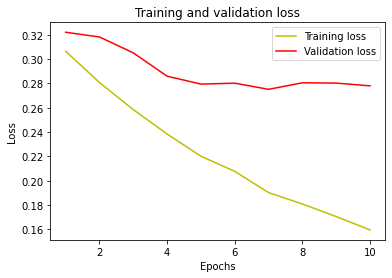

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


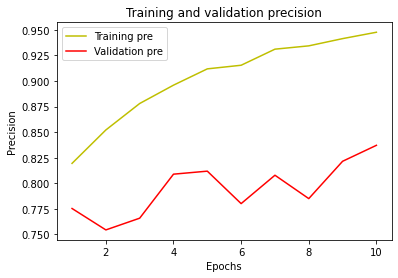

In [18]:
pre= history.history['precision']
val_pre = history.history['val_precision']
plt.plot(epochs, pre, 'y', label='Training pre')
plt.plot(epochs, val_pre, 'r', label='Validation pre')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

#overfitting

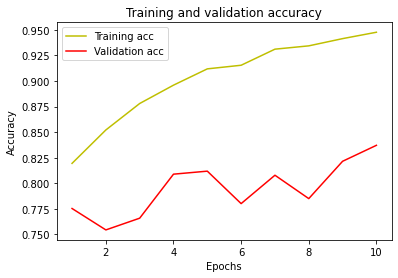

In [19]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, pre, 'y', label='Training acc')
plt.plot(epochs, val_pre, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#overfitting

In [139]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [140]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.43012345


(1, 16, 16, 3)
(16, 16)


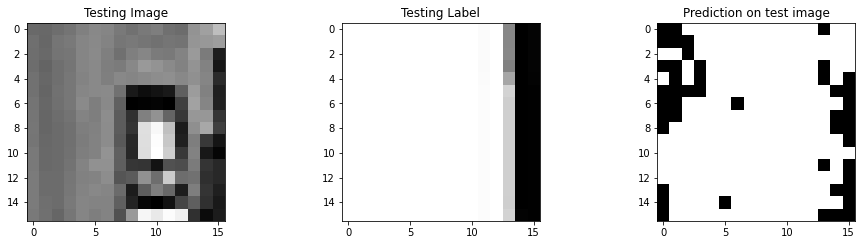

In [170]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()